# Have LLM generate Uniprot SPARQL queries from natural language questions

In this notebook, we ask natural language questions of the Uniprot dataset, have a large-language model (LLM) generate a SPARQL query from the question, and run it against a graph database containing the Uniprot dataset.

The goal is to determine how well the LLM can generate the query. Is the correct query? Does it return expected results? If it does, we gain confidence in the ability to build a natural language question interface to our graph, enabling domain specialists to query the graph without having to know how to write SPARQL queries. 

## How we test it
As the figure below shows, when the user asks a question, we build a prompt for the LLM to generate a SPARQL query. We run that query against the graph database: either your own Amazon Neptune database or the public Uniprot reference SPARQL endpoint.

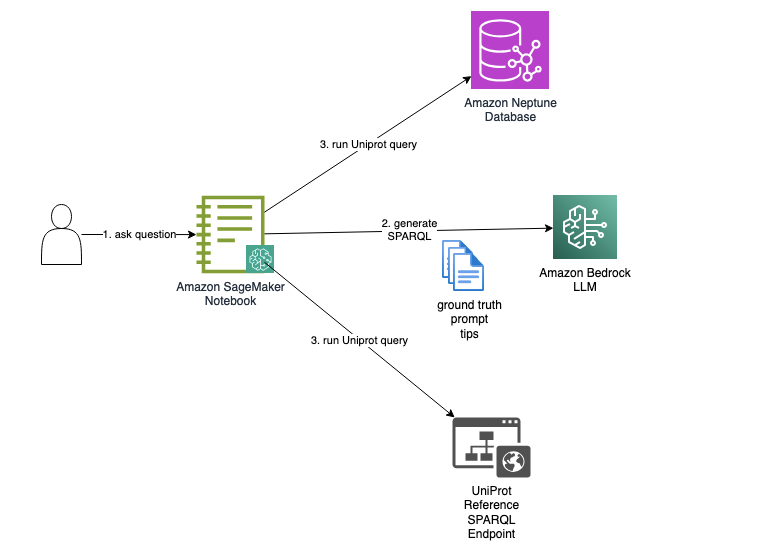

Our LLM is Anthropic Sonnet 3.x, which we access via Amazon Bedrock.

In the  ```resources``` directory are the following files, which we use to build a prompt to the LLM.

1. ```ground-truth.yaml```. A set of ground truth Uniprot queries. We map a natural language question to the equivalent SPARQL query to run on the Uniprot dataset. This gives the LLM numerous examples how to write Uniprot SPARQL queries from natural language question. Here is an excerpt of that file:

```
question: Show me all transmembrane regions
  SPARQL: |
    SELECT  ?protein ?begin ?end
    WHERE
    {
      ?protein  rdf:type     up:Protein ;
                up:annotation  ?annotation .
      ?annotation  rdf:type  up:Transmembrane_Annotation .
      ?annotation up:range ?range .
      ?range faldo:begin ?begin .
      ?range faldo:end ?end .
    }
```

2. ```tips.yaml```. Further instructions for the LLM to follow when writing a SPARQL query for Uniprot. For example:

```
- 'The ec:number of an enzyme is indicated by rdfs:subClassOf'
```

3. ```prefixes.txt```. A list of Uniprot-related prefixes to use for Uniprot SPARQL queries. We ask the LLM to omit prefixes in generated SPARQL queries. We add these prefixes before submitting to graph database. 

4. ```prompt1.yaml```. Template of an LLM prompt asking to generate a SPARQL query based on ground-truth examples and/or tips.

5. ```prompt2.yaml```. Template of an LLM prompt asking for suggestions to improve the SPARQL query generated based on ```prompt.yaml```.

6. ```prompt3.yaml```. Template of an LLM prompt asking to generate a SPARQL query based suggestions from response to prompt based on ```prompt2.yaml```.

In the cells below you can ask a question of your choosing, such as ```What protein is in frogs```.

You can also call ```run_tests()```, which asks each of the *ground truth* questions. For each question, ```run_tests()``` passes to the LLM as context all ground truth examples EXCEPT the example for the question being asked. For example, when to run the question that is at index 2 in ground-truth, ```run_tests()``` passes to the prompt ground truth examples at indices 0, 1, 3, 4, ... 

See README.md for instructions how to setup notebook, Neptune cluster, and Bedrock to run these examples.

## Define dependencies and functions

In [62]:
%pip install -q jinja2==3.1.* langgraph==0.3.* boto3==1.37.* botocore==1.37.*

Note: you may need to restart the kernel to use updated packages.


In [100]:
import os
import csv
import yaml
import json
from pathlib import Path
from typing import List, Union, Optional, TypedDict, Dict, Any
from typing import Any as JsonType
import time
import importlib
from collections import defaultdict
from textwrap import dedent

import boto3
from botocore.config import Config
import jinja2
import pandas as pd
from langgraph.graph import StateGraph, END

import utilities as u


# backoff for Bedrock calls via boto3
config = Config(
   retries = {
      'max_attempts': 5,
      'mode': 'standard'
   }
)

session = boto3.Session()
bedrock_runtime = boto3.client(
    "bedrock-runtime", 
    region_name=u.AWS_REGION if u.AWS_REGION else u.get_sagemaker_region(),
    config=config
)

jenv = jinja2.Environment(trim_blocks=True, lstrip_blocks=True)
model_id = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"
temperature = 0.3
resources = Path.cwd() / "resources"

# load the prefixes, ground-truth examples, and tips
pfx = (Path.cwd() / "resources" / "prefixes.txt").read_text()
ground_truth = yaml.safe_load((resources / "ground-truth.yaml").read_text())
tips = yaml.safe_load((resources / "tips.yaml").read_text())

### This is useful during development:

In [158]:
importlib.reload(u)

<module 'utilities' from '/home/ec2-user/SageMaker/text-to-sparql-on-neptune-with-uniprot/utilities.py'>

#### Load the prompts

In [91]:
prompt_template_json = {i: yaml.safe_load((resources / f"prompt{i}.yaml").read_text())
                        for i in [1, 2, 3]}

#### Set up the Langgraph graph

In [128]:
class State(TypedDict):
    question: str
    few_shot_examples: List[dict]
    tips: List[str]
    draft_SPARQL: str = ""
    suggested_improvements: List[str] = []
    final_SPARQL: str = ""

In [132]:
def generate_SPARQL_agent(state: State) -> Dict[str, Any]:
    prompt = generate_prompt(prompt_template_json[1], suggestions=None,
                             question=state["question"],
                             sparql=None, tips=state["tips"],
                             few_shot_examples=state["few_shot_examples"])
    result_text = run_bedrock(prompt)
    sparql = u.extract_tag("<sparql>"+result_text, "sparql")[0]
    return {"draft_SPARQL": sparql}


def review_SPARQL_agent(state: State) -> Dict[str, Any]:
    prompt = generate_prompt(prompt_template_json[2],
                             question=state["question"], suggestions=None,
                             sparql=state["draft_SPARQL"], tips=state["tips"],
                             few_shot_examples=state["few_shot_examples"])
    result_text = run_bedrock(prompt)
    suggested_improvements = u.extract_multiple_tags("<suggestion>"+result_text,
                                                     "suggestion")
    return {"suggested_improvements": suggested_improvements}


def update_SPARQL_agent(state: State) -> Dict[str, Any]:
    prompt = generate_prompt(prompt_template_json[3],
                              question=state["question"], sparql=state["draft_SPARQL"],
                              tips=state["tips"],
                              few_shot_examples=state["few_shot_examples"],
                              suggestions="\n".join(state["suggested_improvements"]))
    result_text = run_bedrock(prompt)
    final_sparql = u.extract_tag("<sparql>"+result_text, "sparql")[0]
    return {"final_SPARQL": final_sparql}

In [133]:
def create_graph() -> langgraph.graph.state.CompiledStateGraph:
    workflow = StateGraph(State)

    workflow.add_node("generate_SPARQL", generate_SPARQL_agent)
    workflow.add_node("review_SPARQL", review_SPARQL_agent)
    workflow.add_node("update_SPARQL", update_SPARQL_agent)

    workflow.set_entry_point("generate_SPARQL")
    workflow.add_edge("generate_SPARQL", "review_SPARQL")
    workflow.add_edge("review_SPARQL", "update_SPARQL")
    workflow.add_edge("update_SPARQL", END)

    return workflow.compile()

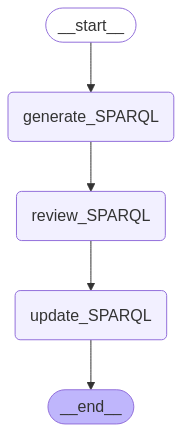

In [134]:
create_graph() # just to see the visualization

## Helpers to generate the SPARQL

In [169]:
def run_bedrock(prompt_json: JsonType) -> str:
    sys_prompt = prompt_json[0]['system']
    messages = prompt_json[1:]
    result_text = u.run_bedrock(system=sys_prompt,
                                messages=messages,
                                temperature=temperature,
                                bedrock_runtime=bedrock_runtime,
                                model_id=model_id)
    return result_text


def apply_jinja(json_blob: JsonType, **kwargs) -> JsonType:
    """
    Interpolate values into the prompt.yaml template using Jinja.
    """
    if isinstance(json_blob, str):
        return jenv.from_string(json_blob).render(**kwargs)
    elif isinstance(json_blob, list):
        return [apply_jinja(x, **kwargs) for x in json_blob]
    elif isinstance(json_blob, dict):
        return {k: apply_jinja(v, **kwargs) for k, v in json_blob.items()}
    else:
        return json_blob


def generate_prompt(prompt_template_json: JsonType,
                    tips: List[str],
                    question: str,
                    sparql: str,
                    few_shot_examples: List[dict],
                    suggestions: str) -> JsonType:
    """
    generate LLM prompt by plugging in values for:
    1. Tips. Leave blank if none.
    2. Ground-truth/few-shot examples. Leave blank if none.
    3. The natural language question.
    """
    # print(f"generate_prompt sparql={sparql}")
    return apply_jinja(prompt_template_json, 
                       question=question,
                       tips=tips,
                       sparql=sparql,
                       examples=few_shot_examples,
                       suggestions=suggestions)


def generate_sparql(tips: List[str],
                    question: str,
                    few_shot_examples: List[dict]) -> List[str]:
    """
    Given a natural language question, use the LLM to transform that
    into a SPARQL query (using the prompt template) and return the query.

    1. Tips. Leave blank if none.
    2. Ground-truth/few-shot examples. Leave blank if none.
    3. The natural language question.

This uses generate_prompt above to form the prompt. It then invokes LLM via Bedrock.
From the response, it extracts th generated SPARQL. 
    """
    initial_state = {
        "question": question,
        "few_shot_examples": few_shot_examples,
        "tips": tips
    }
    # Create and run the graph
    graph = create_graph()
    final_state = graph.invoke(initial_state)
    return final_state

## Setup the test

In [137]:
use_tips = True  # By default use tips in prompt
use_few = True  # By default use few-shot (ground truth) in the prompt
folder_name = "gen_results"  # folder name for results
sparql_fn = u.execute_sparql_uniprotref  # By default use public Uniprot reference

In [194]:
def run_one_test(index: int, print_results: bool = False):
    """
    Run one test where the question is the ground-truth example at the specified index.
    Use_tips and use_few are booleans. Set to control the type of test to run.
    Writes result to {folder_name}/{index}.json.
    If using few-shot, the examples provided are ALL BUT the example at index.
    That way, the LLM does not KNOW ABOUT the question at index but still benefits
    from the other examples.
    """
    the_tips = tips if use_tips else []

    q = ground_truth[index]
    nlq = q['question']
    expected_sparql = q['SPARQL']

    print(f"Question: {nlq}")
    training_examples = []
    if use_few:
        training_examples = ground_truth[:index] + ground_truth[index+1:]
        assert q["SPARQL"] not in {x["SPARQL"] for x in training_examples}

    generated_sparqls = generate_sparql(the_tips, nlq, training_examples)
    # print(f"generated_sparqls: {generated_sparqls}")

    def run_test_attempts(is_orig_used: bool=False,
                          attempt: int=1,
                          attempts_remaining: int=1):
        # goes query g have a limit?
        def has_limit(sparql: str) -> bool:
            try:
                int(sparql.lower().split("limit")[-1].strip())
                return True
            except Exception:
                return False

        which_SPARQL = "draft_SPARQL" if is_orig_used else "final_SPARQL"
        limit = "LIMIT 20" if generated_sparqls[which_SPARQL].strip().startswith("SELECT") \
                              and not has_limit(generated_sparqls[which_SPARQL])\
                           else ""
        sparql = dedent(f"""
            {pfx}

            {generated_sparqls[which_SPARQL]}

            {limit}
            """)
        # print(f"sparql: {sparql}")
        error_msg = ""
        res = None
        try:
            print("Executing SPARQL")
            res = sparql_fn(sparql, session)
            # print(f"res {res}")
            if 'message' in res:
                raise Exception(res['message'].replace("\n", " "))
            if not(folder_name is None):
                rec = u.write_sparql_res(folder_name, str(index), nlq,
                                         expected_sparql,
                                         [generated_sparqls["draft_SPARQL"],
                                          generated_sparqls["final_SPARQL"],
                                          sparql],
                                         res, error_msg, 
                                         is_orig_used=is_orig_used, attempt=attempt)
                
                # if it's blank and we're not using the original, try with the original
                if rec['error_type'] == u.ERR_BLANK and not is_orig_used:
                    attempt += 1
                    run_test_attempts(is_orig_used=True, attempt=attempt,
                                         attempts_remaining=1)
            else:
                #print(nlq)
                print(sparql)
                print(res)

        except Exception as e:
            print(f"Error on {index}")
            print("Exception: {}".format(type(e).__name__))
            print("Exception message: {}".format(e))
            error_msg="Exception message: {}".format(e).replace("\n", " ")
            if folder_name is not None:
                u.write_sparql_res(folder_name, str(index), nlq, q['SPARQL'],
                                   generated_sparqls[which_SPARQL] + [sparql],
                                   [], error_msg, 
                                   is_orig_used=is_orig_used, attempt=attempt)
                attempt += 1
                if attempts_remaining > 0:
                    # we still have attempts remaining, try again
                    run_test_attempts(is_orig_used=is_orig_used,
                                         attempt=attempt, attempts_remaining=0)
                elif not is_orig_used:
                    # we're out of attempts but are not using the original; try with the original
                    run_test_attempts(is_orig_used=True, attempt=attempt,
                                      attempts_remaining=1)

    run_test_attempts()


def run_tests(start_idx=0, end_idx=-1):
    """
    Run all questions from ground-truth. 
    Use_tips and use_few are booleans. Set to control the type of test to run.
    Writes result to {folder_name}/{index}.json.
    """
    folder = f"./{folder_name}" 
    if not(os.path.exists(folder) and os.path.isdir(folder)):
        os.mkdir(folder)

    for index, q in enumerate(ground_truth):
        if index < start_idx:
            continue
        if end_idx >= 0 and index > end_idx:
            break
        print(f"{folder_name} {str(index)}")
        run_one_test(index)


def run_your_own_query(nlq: str):
    """
    Run your own query. The LLM will generate a SPARQL query using
    few+tips approach.

    SPARQL results are printed out.
    """
    training_examples = ground_truth
    generated_sparqls = generate_sparql(tips, nlq, training_examples)
    print(f"Generated draft sparql:\n{generated_sparqls['draft_SPARQL']}")
    print(f"Generated final sparql:\n{generated_sparqls['final_SPARQL']}")
    sparql = f"""
        {pfx}

        {generated_sparqls['final_SPARQL']}

        LIMIT 20
    """
    res = sparql_fn(sparql, session) 
    u.pprint_sparql_results(res)

## Run the tests
Results saved in gen_results folder. 

In [55]:
!rm -rf gen_results

In [56]:
!mkdir -p gen_results

In [ ]:
run_tests()

## One-off queries


In [ ]:
run_one_test(1, print_results=True)

In [ ]:
run_your_own_query("What protein is in frogs")